In [1]:
import numpy as np
import qsim
%matplotlib nbagg
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
from matplotlib import cm
from qsim.mps import *
import matplotlib.ticker as tick
from qsim.exact.methods import projection as exact_projection
from qsim.plotting import plot_projections
from qsim.exact.state_vectors import normalise_state_vector, create_random_unentangled_state
from qsim.exact.methods import time_evolution as exact_time_evolution
from qsim.exact.unitaries import create_heisenberg_u

### Make state vectors

In [2]:
num_of_qubits = 4
state_vector_a = create_random_unentangled_state(num_of_qubits)
mps_a = create_specific_mps(state_vector_a)
print('state a is ' + state_vectors_one_to_many(evaluate_mps(mps_a), as_str=True))

state_vector_b = np.zeros(2**num_of_qubits , dtype=complex)
state_vector_b[2] = 1
state_vector_b = normalise_state_vector(state_vector_b)
print('state b is ' + state_vectors_one_to_many(state_vector_b, as_str=True))
mps_b = create_specific_mps(state_vector_b)

state a is 0.0+0.0j |0000>+ -0.0-0.0j |0001>+ -0.1+0.1j |0010>+ 0.2-0.2j |0011>+ -0.0-0.0j |0100>+ -0.0+0.1j |0101>+ 0.3+0.1j |0110>+ -0.7-0.5j |0111>+ -0.0+0.0j |1001>+ 0.0+0.0j |1010>+ -0.0-0.0j |1011>+ -0.0-0.0j |1100>+ 0.0+0.0j |1101>+ 0.0-0.0j |1110>+ -0.0+0.0j |1111>
state b is 1.0+0.0j |0010>


### Exact_heisenberg

<IPython.core.display.Javascript object>


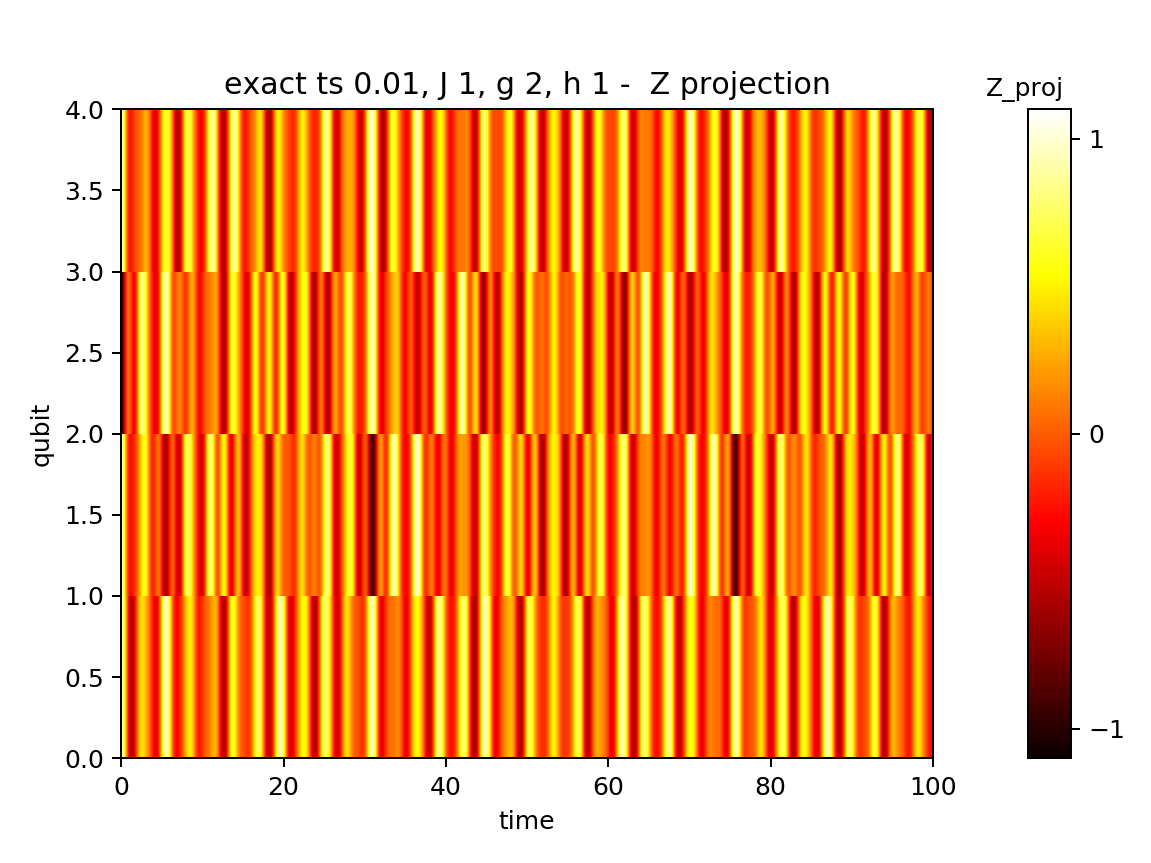

In [28]:
ts = 0.01
t = 100
J = 1
g = 2
h = 1
title = "exact ts {}, J {}, g {}, h {} -  ".format(ts, J, g, h)
time, exact_x = exact_time_evolution([state_vector_b], create_heisenberg_u, ts, t, J=J, h=h, g=g)
pl = plot_projections(exact_x, projection_axes=['Z'], x_axis=time, title=title)
# pl.savefig('Figs/exact_heisenberg.png')

### Even odd Huse

In [29]:
mpo_list = [partial(create_heisenberg_unitary_mpo, even=True),
            partial(create_heisenberg_unitary_mpo, even=False)]

In [30]:
measurements=['intermediary_states', 'entanglement_entropy']

#### specific start

In [32]:
ts = 0.01
t = 100
J = 1
g = 2
h = 1
out = time_evolution(mps_b, mpo_list, ts, t, measurements=measurements, J=J, h=h, g=g, max_d=32)

<IPython.core.display.Javascript object>


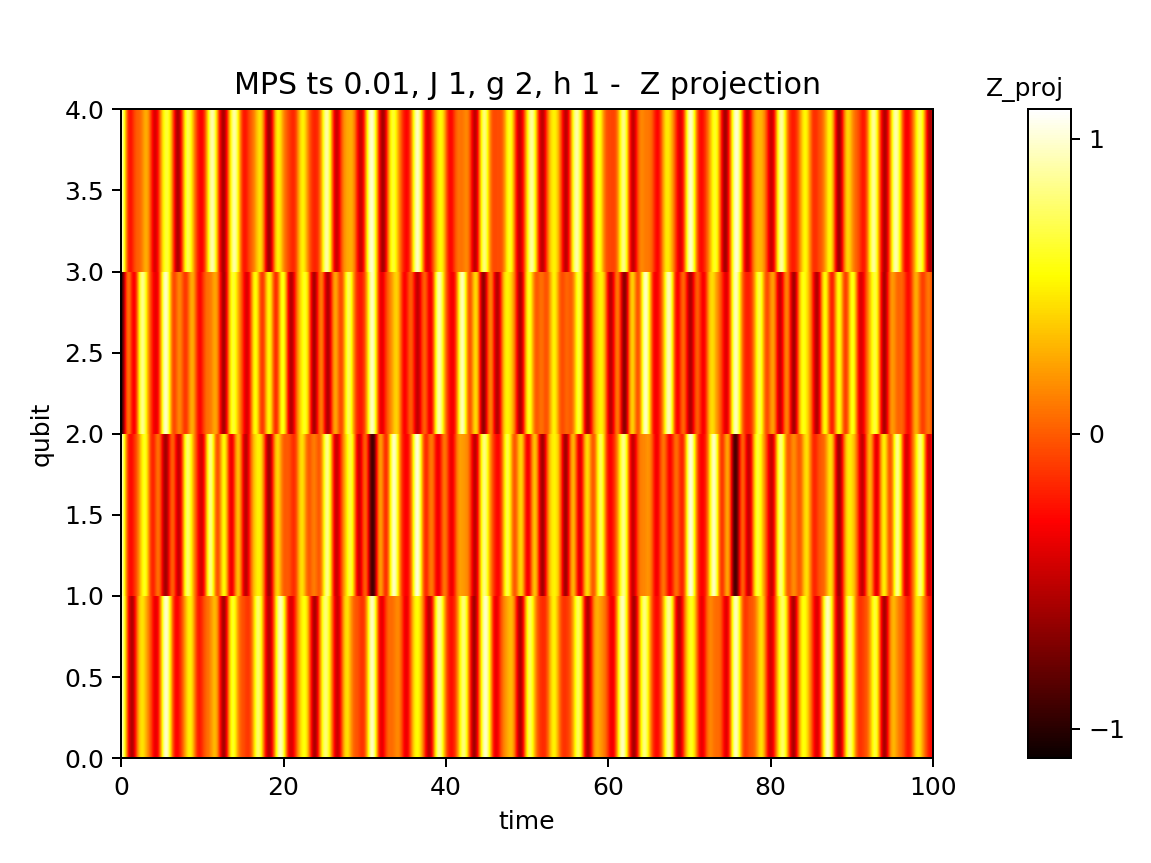

In [33]:
evaluated_array = np.array([evaluate_mps(i) for i in out['intermediary_states']])
title = "MPS ts {}, J {}, g {}, h {} -  ".format(ts, J, g, h)
pl = plot_projections(evaluated_array, projection_axes=['Z'], x_axis=out['time'], title=title)
# pl.savefig('Figs/mps_heisenberg.png')

<IPython.core.display.Javascript object>


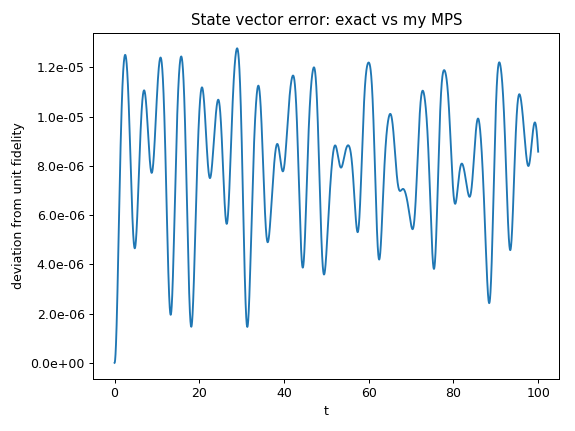

In [51]:
overlap_vals = []
for i, mps_state_v in enumerate(evaluated_array):
    val = 1 - abs(qsim.exact.methods.find_overlap(mps_state_v, exact_x[0, i]))
    overlap_vals.append(val)
fig = plt.figure()
ax = plt.subplot()
ax.plot(time, overlap_vals)
ax.set_xlabel('t')
ax.set_ylabel('deviation from unit fidelity')
ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.1e'))
#     ticker.ScalarFormatter(useMathText=False))
ax.set_title('State vector error: exact vs my MPS')
fig.tight_layout()
fig.savefig('Figs/state_vector_overlap_heisenberg.png')

In [46]:
import json
with open('data4.txt', 'r') as outfile:
    d = json.load(outfile)

In [47]:
alps_q2_proj = np.array(d)
exact_q2_proj = np.real(exact_projection(exact_x[0])[:, 2])
mps_q2_proj = np.real(exact_projection(evaluated_array)[:, 2])

<IPython.core.display.Javascript object>


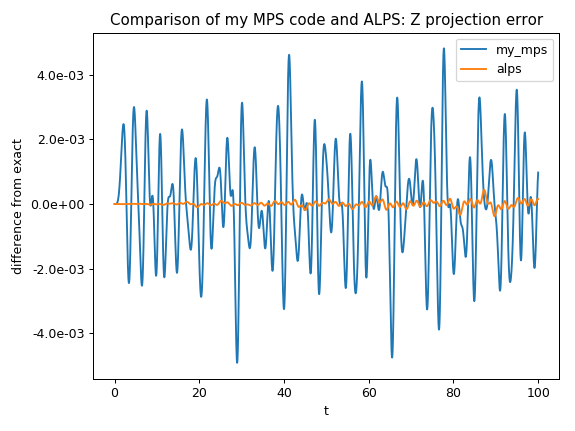

In [49]:
overlap_vals = []
for i, mps_state_v in enumerate(evaluated_array):
    val = 1 - abs(qsim.exact.methods.find_overlap(mps_state_v, exact_x[0, i]))
    overlap_vals.append(val)
fig = plt.figure()
ax = plt.subplot()
ax.plot(time[1:], mps_q2_proj[1:] - exact_q2_proj[1:], label='my_mps')
ax.plot(time[1:], alps_q2_proj - exact_q2_proj[1:], label='alps')
ax.set_xlabel('t')
ax.set_ylabel('difference from exact')
ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.1e'))
ax.set_title('Comparison of my MPS code and ALPS: Z projection error')
plt.legend()
fig.tight_layout()
fig.savefig('Figs/z_projection_error_heisenberg.png')

In [15]:
import json
with open('data2.txt', 'r') as outfile:
    d = json.load(outfile)

In [16]:
alps_ent = np.array(d)
# exact_ent = np.real(exact_projection(exact_x[0])[:, 2])
mps_ent = out['entanglement_entropy']

<IPython.core.display.Javascript object>


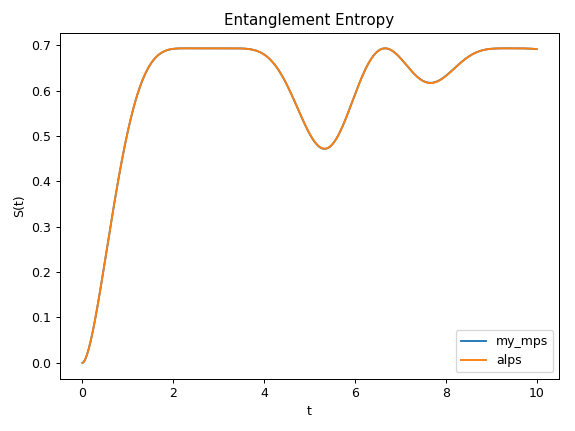

In [27]:
fig = plt.figure()
ax = plt.subplot()
ax.plot(out['time'], mps_ent, label='my_mps')
ax.plot(out['time'][1:], alps_ent, label='alps')
ax.set_title('Entanglement Entropy')
ax.set_xlabel('t')
ax.set_ylabel('S(t)')
plt.legend()
fig.tight_layout()
fig.savefig('Figs/entropy_heisenberg.png')

In [ ]:
fig = plt.figure()
ax = plt.subplot()
ax.plot(out['time'], out['Z'], label='Z')
ax.set_title('time_step 0.02, max_d 10')
ax.set_xlabel('t')
ax.set_ylabel('Z')
plt.legend()

#### random start

In [40]:
max_d = 50
num_avg = 3
time= 150
ts = 0.05
J = 1
h = (1 + np.sqrt(5)) / 4
g = (5 + np.sqrt(5)) / 8
entr_list = []
for j in np.linspace(8, 16, num=3):
    ent_entropy = np.zeros(int(time / ts) + 1)
    for i in range(num_avg):
        state_vector_a = create_random_unentangled_state(j)
        mps_a = create_specific_mps(state_vector_a)
        new_out = time_evolution(mps_a, mpo_list, ts, time, measurements=measurements, J=J, h=h, g=g, max_d=max_d)
        ent_entropy += np.array(new_out['entanglement_entropy'])
        print('{} qubits, rep {}'.format(j, i))
    ent_entropy /= num_avg
    
    entr_list.append(ent_entropy)

8.0 qubits, rep 0
8.0 qubits, rep 1
8.0 qubits, rep 2
12.0 qubits, rep 0
12.0 qubits, rep 1
12.0 qubits, rep 2
16.0 qubits, rep 0
16.0 qubits, rep 1
16.0 qubits, rep 2


<IPython.core.display.Javascript object>


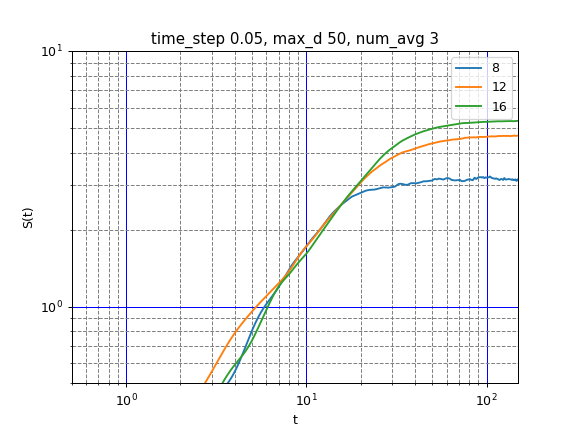

In [43]:
fig = plt.figure()
ax = plt.subplot()
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(b=True, which='major', color='b', linestyle='-')
ax.grid(b=True, which='minor', color='grey', linestyle='--')
ax.set_ylim(5 * 10**-1, 10**1)
ax.set_xlim(5 * 10**-1, 150)
# ax.plot(new_out['time'], entr_list[0], label='4')
ax.plot(new_out['time'], entr_list[0], label='8')
ax.plot(new_out['time'], entr_list[1], label='12')
ax.plot(new_out['time'], entr_list[2], label='16')
# ax.plot(new_out['time'], entr_list[3], label='14')
# ax.plot(new_out['time'], entr_list[4], label='16')
ax.set_title('time_step {}, max_d {}, num_avg {}'.format(ts, max_d, num_avg))
ax.set_xlabel('t')
ax.set_ylabel('S(t)')
plt.legend()
fig.savefig('fourth_attempt')

### XZ Huse

In [51]:
mpo_list = [create_Huse_unitary_mpo_x,
            partial(create_Huse_unitary_mpo_z, even=False),
            partial(create_Huse_unitary_mpo_z, even=True)]

In [ ]:
measurements=['entanglement_entropy', 'Z', 'intermediary_states']

#### specific start

In [52]:
J = 1
h = 1
g = 2
out = time_evolution(mps_a, mpo_list, 0.01, 10, measurements=measurements, J=J, h=h, g=g, max_d=8)

<IPython.core.display.Javascript object>


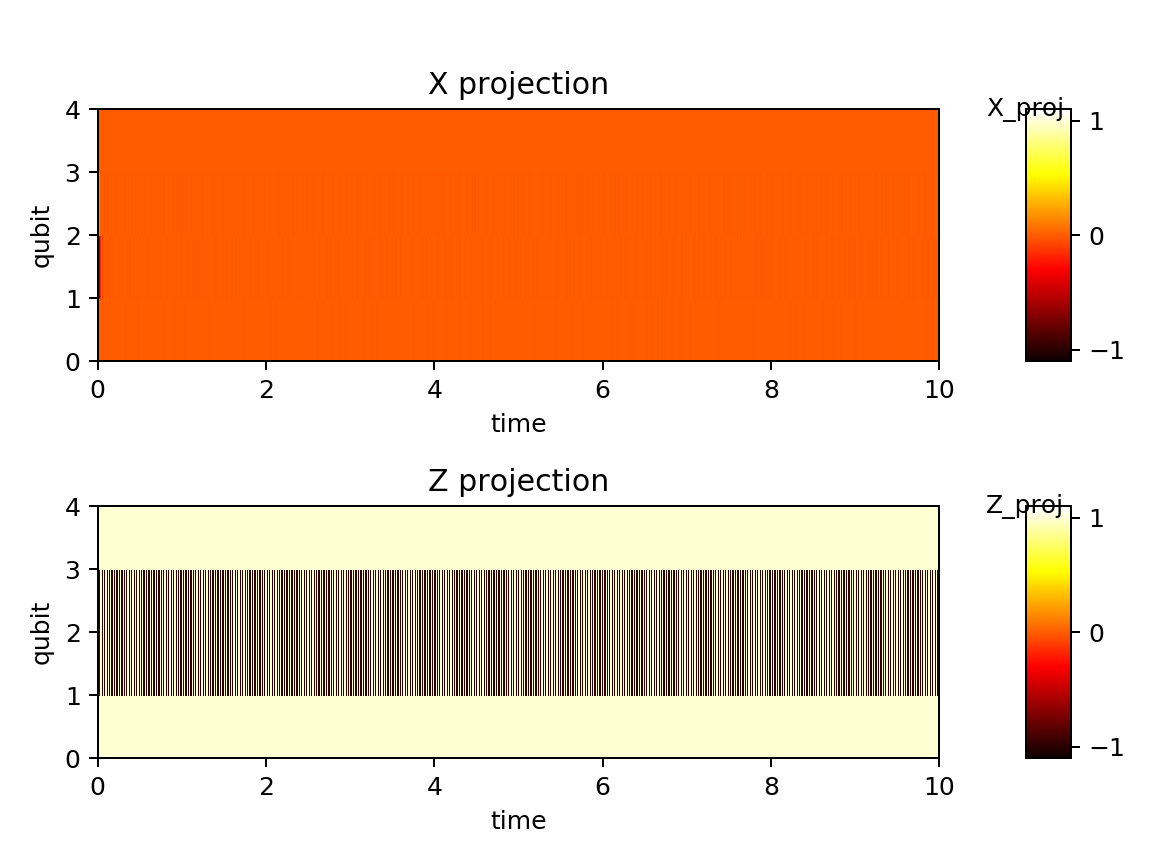

In [53]:
evaluated_array = np.array([evaluate_mps(i) for i in out['intermediary_states']])
pl = plot_projections(evaluated_array, projection_axes=['X', 'Z'], x_axis=out['time'])
pl.savefig('XZ_mps_XZ_max_d_8.png')

In [ ]:
fig = plt.figure()
ax = plt.subplot()
ax.plot(out['time'], out['entanglement_entropy'], label='entanglement_entropy')
ax.set_title('time_step 0.02, max_d 10')
ax.set_xlabel('t')
ax.set_ylabel('S(t)')
plt.legend()

In [ ]:
fig = plt.figure()
ax = plt.subplot()
ax.plot(out['time'], out['Z'], label='Z')
ax.set_title('time_step 0.02, max_d 10')
ax.set_xlabel('t')
ax.set_ylabel('Z')
plt.legend()

#### random start

In [ ]:
J = 1
h = (1 + np.sqrt(5)) / 4
g = (5 + np.sqrt(5)) / 8
out = time_evolution(mps_a, mpo_list, 0.02, 20, measurements=measurements, J=J, h=h, g=g, max_d=10)
ent_entropy = np.array(out['entanglement_entropy'])
for i in range(5):
    state_vector_a = create_random_unentangled_state(num_of_qubits)
    mps_a = create_specific_mps(state_vector_a)
    new_out = time_evolution(mps_a, mpo_list, 0.02, 20, measurements=measurements, J=J, h=h, g=g, max_d=10)
    ent_entropy += np.array(new_out['entanglement_entropy'])
ent_entropy /= 6

In [ ]:
fig = plt.figure()
ax = plt.subplot()
ax.plot(out['time'], ent_entropy, label='entanglement_entropy')
ax.set_title('time_step 0.01, max_d 10')
ax.set_xlabel('t')
ax.set_ylabel('S(t)')
plt.legend()

In [ ]:
output_list = []
J = 1
h = (1 + np.sqrt(5)) / 4
g = (5 + np.sqrt(5)) / 8
for i in np.linspace(8, 16, num=5):
    state_vector_a = create_random_unentangled_state(i)
    print('{} in progress'.format(i))
    mps_a = create_specific_mps(state_vector_a)
    output_list.append(time_evolution(mps_a, mpo_list, 0.01, 40, measurements=measurements, J=J, h=h, g=g, max_d=40))

8.0 in progress
10.0 in progress


<IPython.core.display.Javascript object>


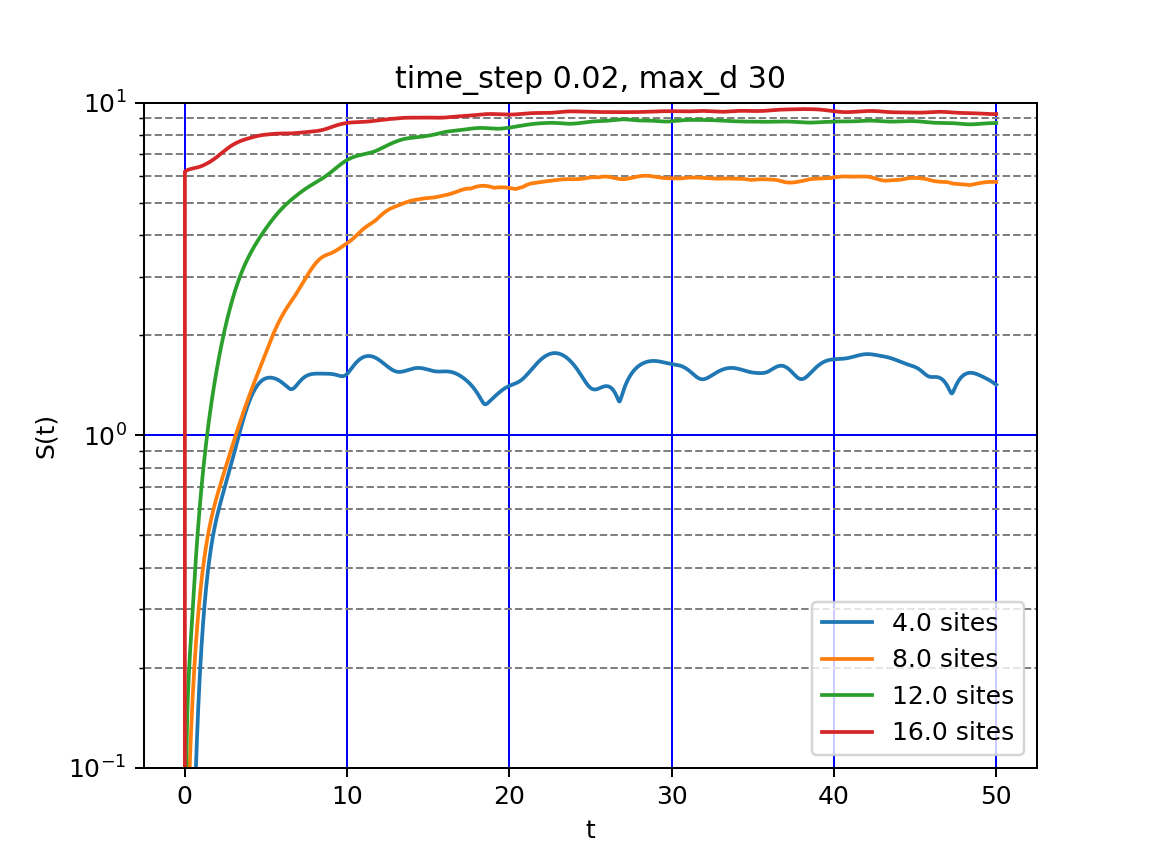

In [35]:
fig = plt.figure()
ax = plt.subplot()
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(b=True, which='major', color='b', linestyle='-')
ax.grid(b=True, which='minor', color='grey', linestyle='--')
ax.set_ylim(10**-1, 10**1)
# ax.set_xlim(10**-1, 10**2)
nums = np.linspace(4, 16, num=4)
for i, output in enumerate(output_list):
    ax.plot(output['time'], output['entanglement_entropy'], label='{} sites'.format(nums[i]))
ax.set_title('time_step 0.02, max_d 30')
ax.set_xlabel('t')
ax.set_ylabel('S(t)')
plt.legend()

In [34]:
fig.savefig('first_attempt.png')

In [5]:
J = 1
h = (1 + np.sqrt(5)) / 4
g = (5 + np.sqrt(5)) / 8
out = time_evolution(mps_a, mpo_list, 0.02, 20, measurements=measurements, J=J, h=h, g=g, max_d=10)
ent_entropy = np.array(out['entanglement_entropy'])
# Z_vals = np.array(out['Z'])
for i in range(5):
    state_vector_a = create_random_unentangled_state(num_of_qubits)
    mps_a = create_specific_mps(state_vector_a)
    new_out = time_evolution(mps_a, mpo_list, 0.02, 20, measurements=measurements, J=J, h=h, g=g, max_d=10)
    ent_entropy += np.array(new_out['entanglement_entropy'])
ent_entropy /= 6

<IPython.core.display.Javascript object>


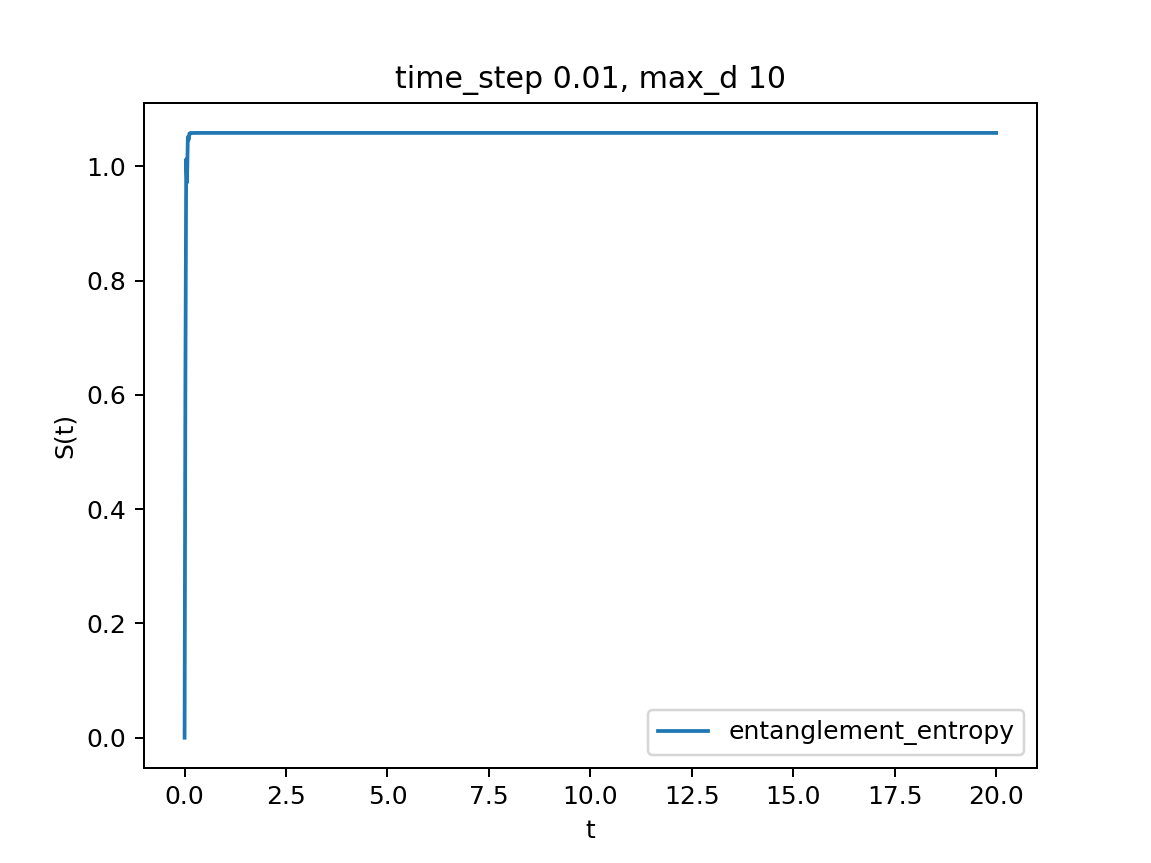

In [6]:
fig = plt.figure()
ax = plt.subplot()
ax.plot(out['time'], ent_entropy, label='entanglement_entropy')
ax.set_title('time_step 0.01, max_d 10')
ax.set_xlabel('t')
ax.set_ylabel('S(t)')
plt.legend()

<IPython.core.display.Javascript object>


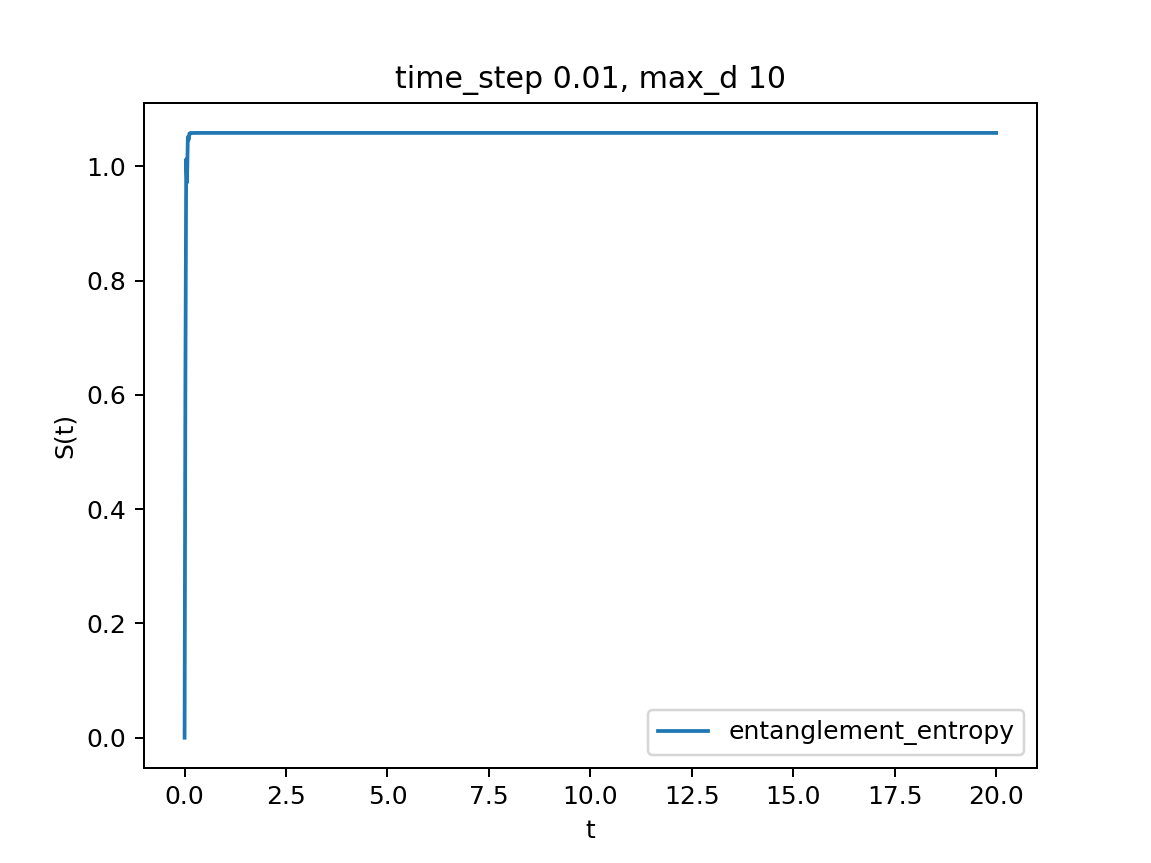

In [7]:
fig = plt.figure()
ax = plt.subplot()
ax.plot(out['time'], ent_entropy, label='entanglement_entropy')
ax.set_title('time_step 0.01, max_d 10')
ax.set_xlabel('t')
ax.set_ylabel('S(t)')
plt.legend()